In [ ]:
!pip install pyLDAvis
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update

! pip install konlpy
!pip install ujson
! pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Data Preprocessing Package
import re                       #정규식
import numpy as np
import pandas as pd
import os                      #디렉토리와 경로정보

# NLP Package
from konlpy.tag import * 
import gensim                    #토픽모델링을 하는 라이브러리
import gensim.corpora as corpora #텍스트분석
from gensim.models import CoherenceModel
from collections import Counter
import nltk

# # Visualization Package   

import pyLDAvis 
import pyLDAvis.gensim_models 
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
from matplotlib import font_manager
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

from PIL import Image
plt.rcParams['font.family'] = 'NanumGothic'
mpl.matplotlib_fname()
%config InlineBackend.figure_format = 'retina'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
from pprint import pprint #pretty print
import itertools #iterable 객체 처리
import math

import logging #로그처리
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings #경고 무시
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_rows', 200)

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
# 기본 저장 주소
ROOT_PATH ="/content/drive/MyDrive"
# 데이터 저장 주소(low)
                 
DATA_STOP_WORD_FILE_NAME = os.path.join(ROOT_PATH + '/stopword.txt')   # 불용어 사전 

# 모델 저장 주소

LDA_MODEL_SAVE_NAME = os.path.join(ROOT_PATH+ "/ABC_BERT/model/Model_lda_topic_modeling.lda")
OPT_MODEL_SAVE_NAME = os.path.join(ROOT_PATH+ "/ABC_BERT/model/Model_opt_topic_modeling.lda")

# # 결과물 저장 주소

RESULT_SAVE_LDAVIS = os.path.join(ROOT_PATH+ "/ABC_BERT/result/Result_lda_vis_negative.html")
RESULT_TOPIC_EXCEL = os.path.join(ROOT_PATH +"/ABC_BERT/result/Result_topic_excel_negative.xlsx")
RESULT_corpus_EXCEL = os.path.join(ROOT_PATH +"/ABC_BERT/result/Result_corpus_excel_negative.xlsx")



> # 데이터 불러오기



In [ ]:
# 데이터 불러오기 
df = pd.read_csv("/content/drive/MyDrive/ABC_BERT/ABC_review_low") 
print(len(df))
# # 불러온 데이터의 값이 비어 있는지 확인
print('Null값이 있는지 확인합니다.',df.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')

print('중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다.', df.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')


394
Null값이 있는지 확인합니다. False

중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다. False



In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,USER,DATE,STAR,LIKE,TITLE,REVIEW
0,0,0,dddd.d,2023-02-06 18:35:42-07:00,1.0,0,개느림 진짜 미치게느림,처음에 내 폰이 문젠줄알고 개당황했는데 앱자체가 미치게느려서 그냥 아무것도 할수가없...
1,1,1,ㄴㅇㅏ,2023-02-01 20:13:29-07:00,1.0,0,쿠폰을 줘도 못씀,쿠폰 준다고 앱 깔아서 카카오톡 친구 추가까지 했는데 일부 상품 제외라면서 할인 안...
2,2,2,LeoL🦁🦁,2023-01-20 17:12:46-07:00,1.0,0,ㄱㅂㅅ,진짜 최악이네요 주문한 상품의 결제가 어느순간 보니 취소되어있지 않나 고객센터는 전...
3,3,3,엑릭릭릭,2023-01-14 23:03:18-07:00,1.0,0,별점도 아까운 어플임,ABC마트가 망한다면 90%는 이 어플때문임\n반응속도부터 물건 찾는것도 ㅈㄹ 같고...
4,4,4,".,?..ㄷ",2023-01-11 17:45:23-07:00,1.0,0,최악의 쓰레기 어플,그냥 속도만 보면 답답해서 회원탈퇴하고싶게 만드는 앱\n걍 탈퇴함
...,...,...,...,...,...,...,...,...
389,503,3,피드백입니당,2020-03-13 18:39:13-07:00,1.0,0,아니 응모 할라는데,무슨 회원가입할때 휴대폰 인증하라하고 또 응모할때 또 쳐하라니까 했는데 무슨 요청할...
390,504,4,옹옹옹오오,2020-03-08 18:11:07-07:00,1.0,0,앱 왜 만드신건가요..,로그인하면 오류 뜨고.. 웹기반이면 어플 없애고 웹으로만 하세요...
391,505,5,심시티의 어느심,2020-02-23 02:23:01-07:00,1.0,0,어플 개판이네,반응속도도 구리고 사이즈도 안뜨고 쿠폰 적용상품인데 쿠폰적용도안됨
392,506,6,얌채ㅋ,2020-02-21 01:49:03-07:00,1.0,0,어플좀 신경 써서 만드세요,인터페이스가 별로고 반응속도도 느려서 영 못쓰겠네요 그리고 검색해서 품목들 나오는데...


In [ ]:
#별점 type변환
df.STAR = df.STAR.astype(float)
#별점 나누기
# tmp_low=df[df['STAR']<=3]
# tmp_low.to_csv('ABC_review_low')

# tmp_high=df[df['STAR']>3]
# tmp_high.to_csv('ABC_review_high')



> # 토크나이징(Tokenizing)



In [ ]:
df = df.drop(columns = ["Unnamed: 0",	"Unnamed: 0.1"])

In [ ]:
tokenizer = Twitter() # 토큰나이저 지정
stopword_vocab = DATA_STOP_WORD_FILE_NAME # 불용어 파일 불러오기
sep = "\n" # 불용어 처리 인자

def build_vocab(data_frame,stopword_vocab, separate):
    
    # 불용어 데이터를 가져와 리스트로 변환합니다.
    with open(stopword_vocab, encoding = 'utf-8') as f:
        temp1 = []
        for i in f:
            temp1.append(i)
            
    globals()['stopword_vocab'] = []
    
    # 불용어 데이터는 전역변수 stopword_vocab 선언합니다. 
    # 구분자에 따라 stopword_vocab에 추가하여 불용어 사전을 구축합니다.
    for j in range(len(temp1)):
        temp2 = temp1[j].rstrip(separate)
        globals()['stopword_vocab'].append(temp2)
    
    #품사를 달고 token을 출력합니다.
    globals()['list_sent2words'] =[]
    for i in range(len(data_frame)) :
        num_list=[]
        temp = tokenizer.pos(data_frame[i])
        for j in range(len(temp)):
            num_list.append(temp[j])
        globals()['list_sent2words'].append(num_list)

    return [[word for word in doc if word not in globals()['stopword_vocab']] for doc in globals()['list_sent2words']]

result_data =build_vocab(df['REVIEW'],stopword_vocab, sep)

In [ ]:
#얻은 토큰에서 명사, 형용사,동사만 가져오기
newL=[]
N_POS = ['Noun']  
V_POS = ['Adjective'] 
V_POS1 = ["Verb"] 
for n in range(len(result_data)):
    temp = []
    for k in result_data[n]:
        if k[1] in V_POS:
            temp.append(k[0])
        elif k[1] in N_POS:
            temp.append(k[0])
        elif k[1] in V_POS1 :
            temp.append(k[0])
    newL.append(temp)
print(newL)

[['처음', '내', '폰', '젠줄알', '개', '당황', '했는데', '앱', '자체', '미치게', '느려서', '그냥', '것', '할수가', '없는데', '걸', '어플', '그냥', '두는거', '임', '어이', '없네'], ['쿠폰', '준다고', '앱', '깔아서', '카카오', '톡', '친구', '추가', '했는데', '일부', '상품', '제외', '라면', '할인', '안', '해줌', '사기', '당하지', '마셈'], ['진짜', '최악', '요', '주문', '상품', '결제', '순간', '보니', '취소', '되어있지', '않나', '고객', '센터', '전화', '전혀', '받지', '않고', '쓰', '잘데기', '없는', '앱'], ['마트', '망한다면', '는', '이', '어플', '때문', '임', '반응속도', '물건', '찾는것도', '같고', '미친', '브랜드', '기프트카드', '어플', '또', '변환', '해서', '주문', '하냐', '그냥', '사용자', '엿먹으', '만든', '어플', '임'], ['그냥', '속도', '보면', '답답해서', '회원', '탈퇴', '싶게', '만드는', '앱', '탈퇴', '함'], ['광고', '메시지', '수신', '동의', '하던', '거부', '하던', '하나', '뜨고', '멈춥니다', '더', '이상', '넘어가지', '않아요'], ['문의', '남겨도', '보질', '않고', '고객', '센터', '전화', '안', '받음', '거', '관리', '하는', '사람', '있긴', '함', '개', '빡치네', '것', '앱', '만들어놨나'], ['결제', '불가능해서', '어플', '의미', '없음'], ['그냥', '선택', '일', '수', '있음', '좋겠어요'], ['고려시대', '때', '쓰던거냐', '개', '발암', '걸리겠', '넼'], ['아니', '진짜', '무슨', '조선', '컴', '마냥', '개', '답답하고', '쿠폰',

In [ ]:
#불용어 제거
def remove_stopwords(text):
    temp2 = []
    for j in range(len(text)) : 
        meaningful_words = [w for w in text[j] if not w in stopword_vocab]
        temp2.append(meaningful_words)
    return temp2

finalL=remove_stopwords(newL)

#길이가 1이상인 단어만 가져오기
num_list = []
for j in range(len(finalL)):
    temp = []
    for k in range(len(finalL[j])):
        if len(finalL[j][k]) > 1:
            temp.append(finalL[j][k])
    num_list.append(temp)

print(num_list)

[['처음', '젠줄알', '당황', '했는데', '자체', '미치게', '느려서', '그냥', '할수가', '없는데', '어플', '그냥', '두는거', '없네'], ['쿠폰', '준다고', '깔아서', '카카오', '친구', '추가', '했는데', '일부', '상품', '제외', '라면', '할인', '해줌', '사기', '당하지', '마셈'], ['진짜', '최악', '주문', '상품', '결제', '순간', '보니', '취소', '되어있지', '않나', '고객', '센터', '전화', '전혀', '받지', '않고', '잘데기', '없는'], ['마트', '망한다면', '어플', '때문', '반응속도', '물건', '찾는것도', '같고', '미친', '브랜드', '기프트카드', '어플', '변환', '해서', '주문', '하냐', '그냥', '사용자', '엿먹으', '만든', '어플'], ['그냥', '속도', '보면', '답답해서', '회원', '탈퇴', '싶게', '만드는', '탈퇴'], ['광고', '메시지', '수신', '동의', '하던', '거부', '하던', '뜨고', '멈춥니다', '넘어가지', '않아요'], ['문의', '남겨도', '보질', '않고', '고객', '센터', '전화', '받음', '관리', '하는', '사람', '있긴', '빡치네', '만들어놨나'], ['결제', '불가능해서', '어플', '의미', '없음'], ['그냥', '선택', '있음', '좋겠어요'], ['고려시대', '쓰던거냐', '발암', '걸리겠'], ['진짜', '조선', '마냥', '답답하고', '쿠폰', '대상', '되는', '신발', '보려다가', '화면', '가려고', '하면', '처음', '돌아가고', '쿠폰', '쓰려면', '고르자마자', '구매', '결제', '써야하는', '수준', '진짜', '처음', '화면', '몇번', '보는', '건지', '신발', '사는데', '걸리게', '만들면', '어쩌', '건지', '진짜', '하기전에', '관리

In [ ]:
#추가 불용어제거
stopword = ['같아요','나서','된게','없애고','스팟','품목','하세요','이따','할수','건지','해도','해서','하면','신발','매장','마트','제주도','어플','젠줄알','자체','라면','마셈','있는','때문','같고','진짜','사나','있습니까','라라','하라','대한','계속','통합','그냥','다시','제대로','제발']
LL=[]
for j in range(len(num_list)):
    temp = [i for i in num_list[j] if i not in stopword]
    LL.append(temp)
print(LL)

[['처음', '당황', '했는데', '미치게', '느려서', '할수가', '없는데', '두는거', '없네'], ['쿠폰', '준다고', '깔아서', '카카오', '친구', '추가', '했는데', '일부', '상품', '제외', '할인', '해줌', '사기', '당하지'], ['최악', '주문', '상품', '결제', '순간', '보니', '취소', '되어있지', '않나', '고객', '센터', '전화', '전혀', '받지', '않고', '잘데기', '없는'], ['망한다면', '반응속도', '물건', '찾는것도', '미친', '브랜드', '기프트카드', '변환', '주문', '하냐', '사용자', '엿먹으', '만든'], ['속도', '보면', '답답해서', '회원', '탈퇴', '싶게', '만드는', '탈퇴'], ['광고', '메시지', '수신', '동의', '하던', '거부', '하던', '뜨고', '멈춥니다', '넘어가지', '않아요'], ['문의', '남겨도', '보질', '않고', '고객', '센터', '전화', '받음', '관리', '하는', '사람', '있긴', '빡치네', '만들어놨나'], ['결제', '불가능해서', '의미', '없음'], ['선택', '있음', '좋겠어요'], ['고려시대', '쓰던거냐', '발암', '걸리겠'], ['조선', '마냥', '답답하고', '쿠폰', '대상', '되는', '보려다가', '화면', '가려고', '처음', '돌아가고', '쿠폰', '쓰려면', '고르자마자', '구매', '결제', '써야하는', '수준', '처음', '화면', '몇번', '보는', '사는데', '걸리게', '만들면', '어쩌', '하기전에', '관리자', '시험', '심아', '테스트', '놔요', '답답해서', '있어야지', '쿠폰', '할인', '이하라면서', '할인', '되는', '제품', '쿠폰', '할인', '적용', '돼요', '사람', '가지', '노나요', '연말', '다가오고', '하니까', '사는거지', '결제', '

In [ ]:
# 전체 에 대한 워드 카운트 계수 확인

def word_corpus(result_data):
    #전체 단어의 갯수 파악
    words = list(itertools.chain(*result_data))
    print('전체 워드의 개수 : {}'.format(len(words)))

    #단어의 빈도수를 확인 후 추가할 불용어 확인 작업
    vocab = Counter(words)
    vocab_size = len(words)
    vocab = vocab.most_common(vocab_size) # 등장 빈도수가 높은 상위 n개의 단어만 저장 vocab
    return vocab

vocab=word_corpus(LL)
print(vocab)
# 전체 워드의 빈도 계수 
df_corpus=pd.DataFrame(columns=["text","count"])
tmp_list=[]
tmp_list1=[]
for word, num in vocab:
    tmp_list.append(word)
    tmp_list1.append(num)
df_corpus['text']=tmp_list
df_corpus['count']=tmp_list1
#상위 20개의 워드 카운드 계수만 출력
a=df_corpus.head(1000)
print(df_corpus.head(20))

#빈도분석한 결과를 별도의 파일에 저장함
a.to_excel(RESULT_corpus_EXCEL ,sheet_name = "sheet2low")


전체 워드의 개수 : 4487
[('로그인', 74), ('오류', 59), ('검색', 31), ('쿠폰', 30), ('처음', 29), ('안되고', 27), ('상품', 25), ('결제', 25), ('회원', 23), ('화면', 22), ('적용', 22), ('서버', 22), ('뜨고', 20), ('느리고', 20), ('가입', 20), ('페이지', 20), ('쓰레기', 20), ('연결', 20), ('리뷰', 19), ('서비스', 19), ('접속', 19), ('구매', 18), ('하려고', 18), ('자꾸', 18), ('가기', 18), ('했는데', 17), ('하고', 17), ('않고', 16), ('만든', 15), ('하는', 15), ('개선', 15), ('안됨', 15), ('원활하지', 15), ('주문', 14), ('사용', 14), ('인증', 14), ('되고', 14), ('개발자', 14), ('하는데', 14), ('누르면', 14), ('안되네요', 14), ('사람', 13), ('버튼', 13), ('관리', 12), ('같은', 12), ('필터', 12), ('없네요', 12), ('수가', 12), ('하지', 12), ('비밀번호', 12), ('정말', 12), ('자동', 11), ('보고', 11), ('업데이트', 11), ('않음', 11), ('사이트', 11), ('비번', 11), ('생각', 10), ('입력', 10), ('정도', 10), ('로딩', 10), ('데이터', 10), ('네트워크', 10), ('알림', 10), ('할인', 9), ('고객', 9), ('속도', 9), ('답답해서', 9), ('없음', 9), ('삭제', 9), ('해주세요', 9), ('입니다', 9), ('번호', 9), ('걸리고', 9), ('도대체', 9), ('아니고', 9), ('수정', 9), ('되는', 8), ('테스트', 8), ('다운', 8), ('마세요



> # 단어 빈도수 시각화




In [ ]:
#한 리스트에 담아주기
title = []
for n in range(len(LL)):
    for word in LL[n] :
        title.append(word)
title

['처음',
 '당황',
 '했는데',
 '미치게',
 '느려서',
 '할수가',
 '없는데',
 '두는거',
 '없네',
 '쿠폰',
 '준다고',
 '깔아서',
 '카카오',
 '친구',
 '추가',
 '했는데',
 '일부',
 '상품',
 '제외',
 '할인',
 '해줌',
 '사기',
 '당하지',
 '최악',
 '주문',
 '상품',
 '결제',
 '순간',
 '보니',
 '취소',
 '되어있지',
 '않나',
 '고객',
 '센터',
 '전화',
 '전혀',
 '받지',
 '않고',
 '잘데기',
 '없는',
 '망한다면',
 '반응속도',
 '물건',
 '찾는것도',
 '미친',
 '브랜드',
 '기프트카드',
 '변환',
 '주문',
 '하냐',
 '사용자',
 '엿먹으',
 '만든',
 '속도',
 '보면',
 '답답해서',
 '회원',
 '탈퇴',
 '싶게',
 '만드는',
 '탈퇴',
 '광고',
 '메시지',
 '수신',
 '동의',
 '하던',
 '거부',
 '하던',
 '뜨고',
 '멈춥니다',
 '넘어가지',
 '않아요',
 '문의',
 '남겨도',
 '보질',
 '않고',
 '고객',
 '센터',
 '전화',
 '받음',
 '관리',
 '하는',
 '사람',
 '있긴',
 '빡치네',
 '만들어놨나',
 '결제',
 '불가능해서',
 '의미',
 '없음',
 '선택',
 '있음',
 '좋겠어요',
 '고려시대',
 '쓰던거냐',
 '발암',
 '걸리겠',
 '조선',
 '마냥',
 '답답하고',
 '쿠폰',
 '대상',
 '되는',
 '보려다가',
 '화면',
 '가려고',
 '처음',
 '돌아가고',
 '쿠폰',
 '쓰려면',
 '고르자마자',
 '구매',
 '결제',
 '써야하는',
 '수준',
 '처음',
 '화면',
 '몇번',
 '보는',
 '사는데',
 '걸리게',
 '만들면',
 '어쩌',
 '하기전에',
 '관리자',
 '시험',
 '심아',
 '테스트',
 '놔요',
 '답답해서',
 '있어야지',
 '쿠폰',
 '

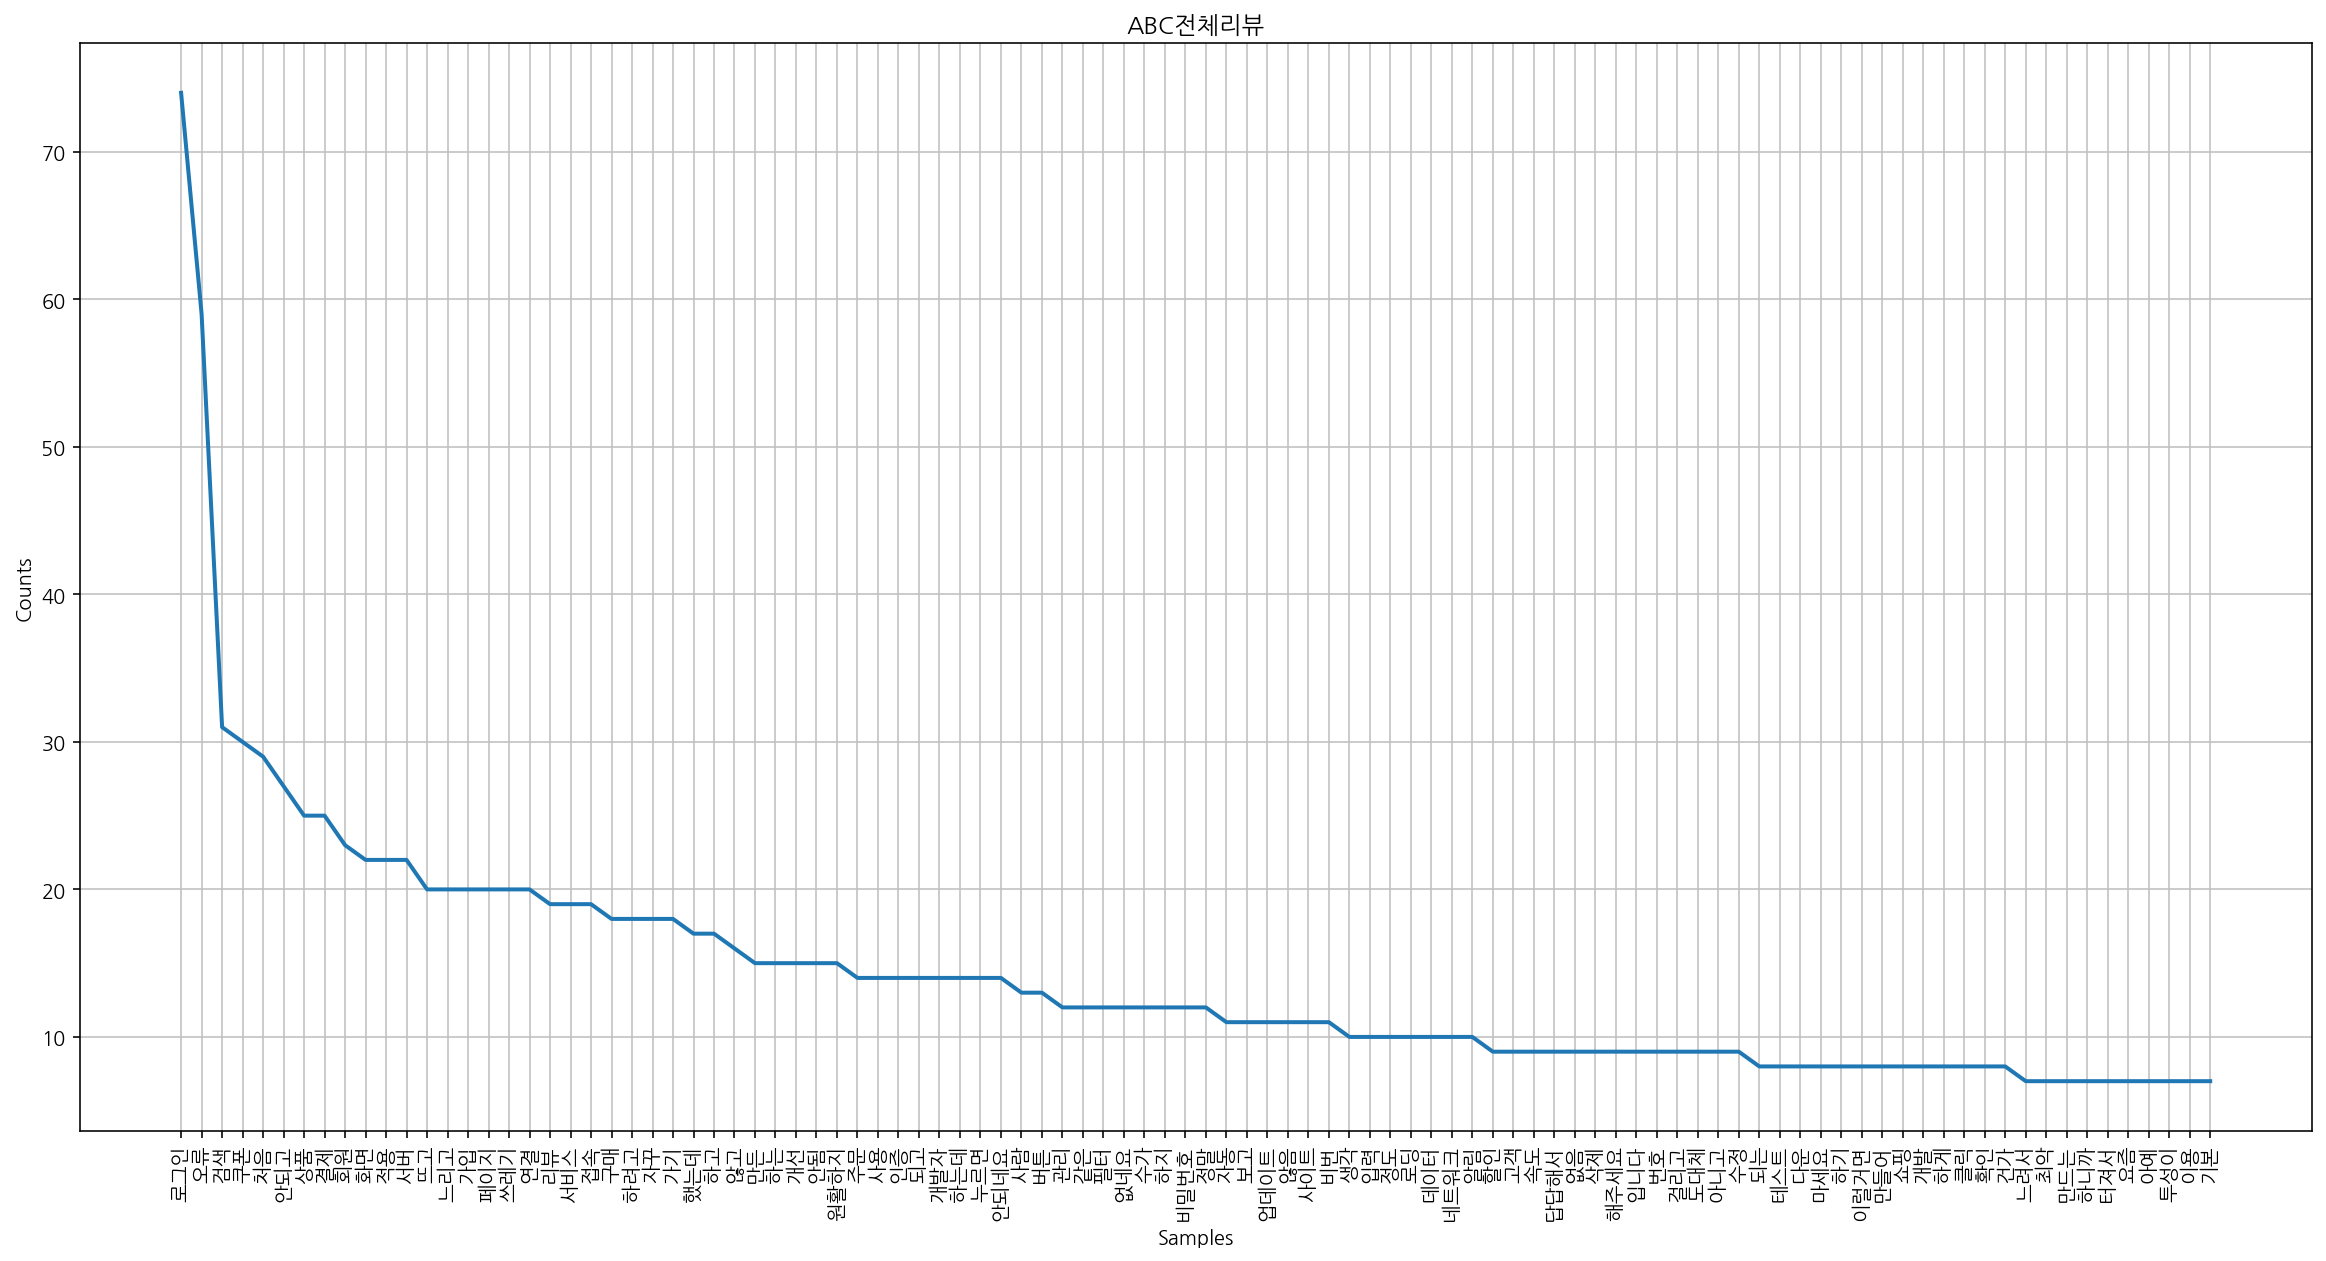

In [ ]:
kor = nltk.Text(title, name='단어 빈도수')
plt.figure(figsize=(20,10))
plt.title("ABC전체리뷰")
kor.plot(100)
plt.show()

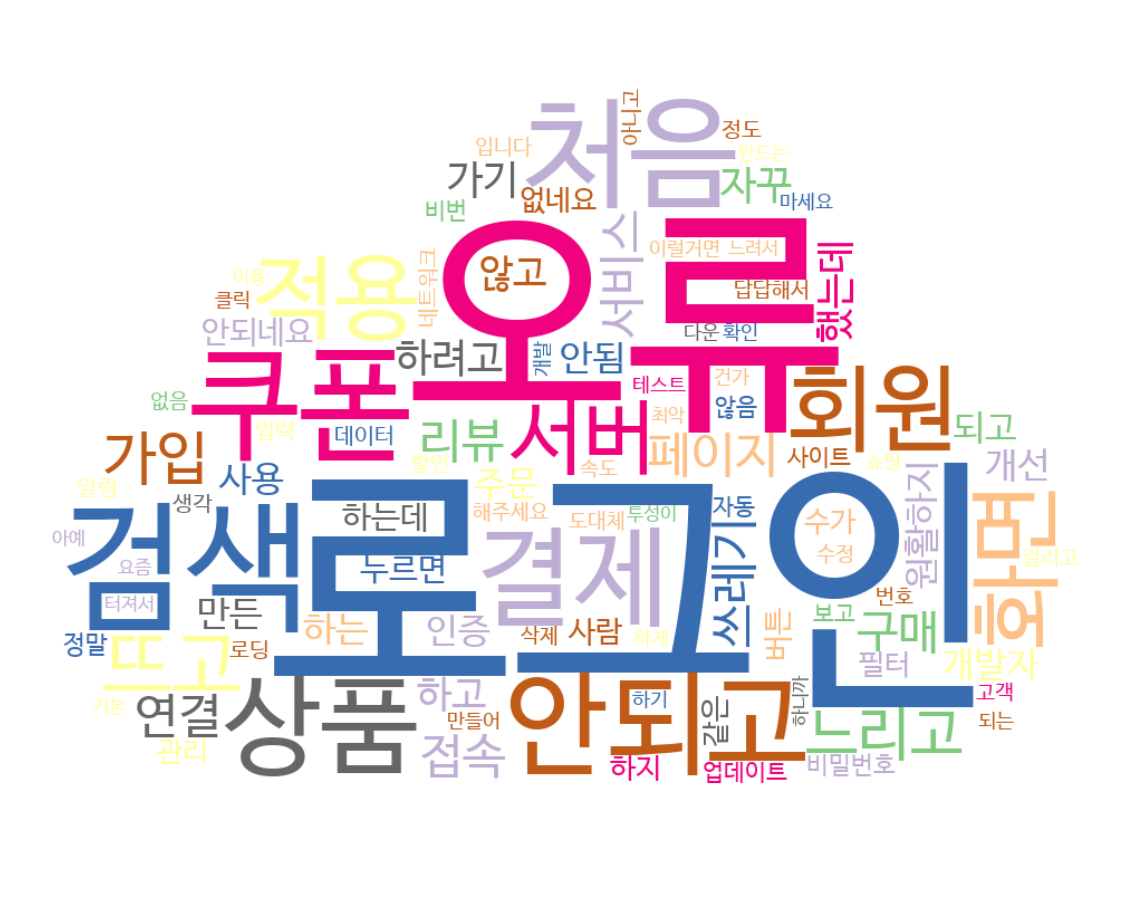

In [ ]:
text_cnt = Counter(kor) #워드클라우드를 만들기 전 불용어 제거한 단어들의 빈도수 저장
img_mask = np.array(Image.open("/content/drive/MyDrive/cloud.png")) #이미지 설정

wordcloud = WordCloud(font_path = fontpath, 
                      background_color='white',
                      colormap = "Accent_r", 
                      mask = img_mask, 
                      random_state = 20, 
                      max_words = 100).generate_from_frequencies(text_cnt)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")        
plt.axis("off")

plt.savefig("ABC_negative.png")
plt.show()



> # LDA



In [ ]:
# 토픽 모델링 딕셔너리 생성
id2word = corpora.Dictionary(LL)
 
# 토픽모델링에 사용할 말뭉치 생성
texts = LL
 
# 용어-문서 빈도
corpus = [id2word.doc2bow(text) for text in texts]

print(id2word)
print(texts)
print(corpus)

Dictionary(2052 unique tokens: ['느려서', '당황', '두는거', '미치게', '없네']...)
[['처음', '당황', '했는데', '미치게', '느려서', '할수가', '없는데', '두는거', '없네'], ['쿠폰', '준다고', '깔아서', '카카오', '친구', '추가', '했는데', '일부', '상품', '제외', '할인', '해줌', '사기', '당하지'], ['최악', '주문', '상품', '결제', '순간', '보니', '취소', '되어있지', '않나', '고객', '센터', '전화', '전혀', '받지', '않고', '잘데기', '없는'], ['망한다면', '반응속도', '물건', '찾는것도', '미친', '브랜드', '기프트카드', '변환', '주문', '하냐', '사용자', '엿먹으', '만든'], ['속도', '보면', '답답해서', '회원', '탈퇴', '싶게', '만드는', '탈퇴'], ['광고', '메시지', '수신', '동의', '하던', '거부', '하던', '뜨고', '멈춥니다', '넘어가지', '않아요'], ['문의', '남겨도', '보질', '않고', '고객', '센터', '전화', '받음', '관리', '하는', '사람', '있긴', '빡치네', '만들어놨나'], ['결제', '불가능해서', '의미', '없음'], ['선택', '있음', '좋겠어요'], ['고려시대', '쓰던거냐', '발암', '걸리겠'], ['조선', '마냥', '답답하고', '쿠폰', '대상', '되는', '보려다가', '화면', '가려고', '처음', '돌아가고', '쿠폰', '쓰려면', '고르자마자', '구매', '결제', '써야하는', '수준', '처음', '화면', '몇번', '보는', '사는데', '걸리게', '만들면', '어쩌', '하기전에', '관리자', '시험', '심아', '테스트', '놔요', '답답해서', '있어야지', '쿠폰', '할인', '이하라면서', '할인', '되는', '제품', '쿠폰', '할인'

In [ ]:
#documents을 받아서 문서 단어 행렬 만들기
def build_doc_term_mat(documents): 
    
    id2word = corpora.Dictionary(documents) #id2word : 토픽 모델링 딕셔너리
    corpus = [id2word.doc2bow(document) for document in documents] #corpus : 용어-문서 빈도

    return corpus, id2word 
    
    
#단어를 입력하면 단어가 여러 토픽에 해당될 수 있는데 각 토픽에서 갖는 가중치를 표시
def print_term_topics(term, dictionary, model):
    word_id = dictionary.token2id[term]   #단어의 아이디 구함
    print(model.get_term_topics(word_id))  

# 문서에 대한 토픽가중치를 반복하면서 전체 문서에 대해서 표시
def print_doc_topics(model, corpus): 
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
        
        if doc_num == 2:  # 시간 관계상 2번 문서까지만 출력, "0번문서, 1번문서, 2번문서"에 대해서만 해당문서의 토픽가중치를 표시                                     
            break

        print("\n")  

#모델링 후 각 토픽별로 중요한 단어들을 표시
def print_topic_words(model) : 
    for topic_id in range(NUM_TOPICS): 
        topic_word_probs = model.show_topic(topic_id, TOPICS_W_NUM)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
        print("\n")

#LDA 시각화
def create_vis(model):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word, sort_topics=False)
    pyLDAvis.save_html(vis, RESULT_SAVE_LDAVIS)
    return vis

In [ ]:
corpus, id2word = build_doc_term_mat(LL)
print(id2word.token2id) #단어들의 id표시
print(corpus[2][:5]) #예시

{'느려서': 0, '당황': 1, '두는거': 2, '미치게': 3, '없네': 4, '없는데': 5, '처음': 6, '할수가': 7, '했는데': 8, '깔아서': 9, '당하지': 10, '사기': 11, '상품': 12, '일부': 13, '제외': 14, '준다고': 15, '추가': 16, '친구': 17, '카카오': 18, '쿠폰': 19, '할인': 20, '해줌': 21, '결제': 22, '고객': 23, '되어있지': 24, '받지': 25, '보니': 26, '센터': 27, '순간': 28, '않고': 29, '않나': 30, '없는': 31, '잘데기': 32, '전혀': 33, '전화': 34, '주문': 35, '최악': 36, '취소': 37, '기프트카드': 38, '만든': 39, '망한다면': 40, '물건': 41, '미친': 42, '반응속도': 43, '변환': 44, '브랜드': 45, '사용자': 46, '엿먹으': 47, '찾는것도': 48, '하냐': 49, '답답해서': 50, '만드는': 51, '보면': 52, '속도': 53, '싶게': 54, '탈퇴': 55, '회원': 56, '거부': 57, '광고': 58, '넘어가지': 59, '동의': 60, '뜨고': 61, '멈춥니다': 62, '메시지': 63, '수신': 64, '않아요': 65, '하던': 66, '관리': 67, '남겨도': 68, '만들어놨나': 69, '문의': 70, '받음': 71, '보질': 72, '빡치네': 73, '사람': 74, '있긴': 75, '하는': 76, '불가능해서': 77, '없음': 78, '의미': 79, '선택': 80, '있음': 81, '좋겠어요': 82, '걸리겠': 83, '고려시대': 84, '발암': 85, '쓰던거냐': 86, '가려고': 87, '가지': 88, '개선': 89, '걸리게': 90, '고르자마자': 91, '관리자': 92, '구매': 93, '기분': 94, '나오게

In [ ]:
# Perplexity와 Coherence Score 을 판단
# Perplexity는 작을 수록 Coherence Score는 높을 수록 좋다.

TOPICS_W_NUM =20 #토픽 당 단어수는 5개
save_lda_model=0
UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

for i in range(1,30):
  NUM_TOPICS=i
 
  #해당 셀은 토픽모델링(LDA)에 대해 모델을 정의하는 셀
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                              num_topics=NUM_TOPICS, random_state=100, 
                                              update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                              passes=PASSES, alpha='auto', per_word_topics=True)

  doc_lda = lda_model[corpus]

  
  # Perplexity | Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=LL, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()

  print('NUM_TOPICS',NUM_TOPICS,'Perplexity: ', lda_model.log_perplexity(corpus),'Coherence: ', coherence_lda)



NUM_TOPICS 1 Perplexity:  -7.471313177941503 Coherence:  0.2313325403486048
NUM_TOPICS 2 Perplexity:  -7.553150315902893 Coherence:  0.36213656231461233
NUM_TOPICS 3 Perplexity:  -7.63320070325146 Coherence:  0.39836968158114594
NUM_TOPICS 4 Perplexity:  -7.7209245746999695 Coherence:  0.41976155021357264
NUM_TOPICS 5 Perplexity:  -7.816111718044797 Coherence:  0.4628472852909928
NUM_TOPICS 6 Perplexity:  -7.885062144516716 Coherence:  0.44704145336449824
NUM_TOPICS 7 Perplexity:  -7.938528227247671 Coherence:  0.46642948257627254
NUM_TOPICS 8 Perplexity:  -7.972084906889557 Coherence:  0.44439661948852527


KeyboardInterrupt: ignored

In [ ]:
print('토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.')
print(' ')

NUM_TOPICS = int(input('토픽의 개수를 입력해 주세요. ')) #8개
TOPICS_W_NUM = int(input('출력할 토픽별 단어의 개수를 입력해 주세요 ')) #10개
save_lda_model= int(input("선택한 토픽 모델을 저장하시겠습니까? \n0 저장  \n1 미저장  "))  #0 : 저장

UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

#lda 모델 정의
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            num_topics=NUM_TOPICS, random_state=100, 
                                            update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                            passes=PASSES, alpha='auto', per_word_topics=True)

# 토픽 출력
pprint(lda_model.print_topics(num_words=TOPICS_W_NUM))
doc_lda = lda_model[corpus]

# 모델 저장 
if save_lda_model == 0:
    lda_model.save(LDA_MODEL_SAVE_NAME)

토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.
 
토픽의 개수를 입력해 주세요. 5
출력할 토픽별 단어의 개수를 입력해 주세요 15
선택한 토픽 모델을 저장하시겠습니까? 
0 저장  
1 미저장  0
[(0,
  '0.023*"로그인" + 0.020*"오류" + 0.019*"검색" + 0.013*"리뷰" + 0.011*"안되네요" + '
  '0.011*"하는데" + 0.010*"정말" + 0.010*"개선" + 0.009*"비밀번호" + 0.009*"데이터" + '
  '0.008*"수정" + 0.008*"느리고" + 0.008*"가기" + 0.007*"하려고" + 0.007*"와이파이"'),
 (1,
  '0.013*"수가" + 0.012*"인증" + 0.011*"비번" + 0.010*"구매" + 0.008*"했는데" + '
  '0.008*"도대체" + 0.008*"안되고" + 0.008*"가기" + 0.007*"버튼" + 0.007*"사용" + '
  '0.007*"아예" + 0.006*"번호" + 0.006*"메인" + 0.005*"하려고" + 0.005*"해야"'),
 (2,
  '0.019*"오류" + 0.019*"서버" + 0.016*"페이지" + 0.016*"접속" + 0.012*"뜨고" + '
  '0.010*"쓰레기" + 0.008*"알림" + 0.007*"없음" + 0.007*"문제" + 0.007*"처음" + '
  '0.007*"정도" + 0.006*"지금" + 0.006*"회원" + 0.006*"가입" + 0.006*"하는"'),
 (3,
  '0.038*"로그인" + 0.019*"쿠폰" + 0.016*"적용" + 0.016*"상품" + 0.014*"안되고" + '
  '0.014*"자꾸" + 0.011*"회원" + 0.011*"않고" + 0.010*"되고" + 0.009*"사이트" + '
  '0.009*"안됨" + 0.008*"가입" + 0.007*"업데이트" + 0.007*"자동" + 0

In [ ]:
55# 토픽별 키워드 조회
print_topic_words(lda_model)

Topic ID: 0
	로그인	0.023348841816186905
	오류	0.0195888914167881
	검색	0.01920206844806671
	리뷰	0.01294738706201315
	안되네요	0.011284325271844864
	하는데	0.011101835407316685
	정말	0.009860965423285961
	개선	0.009556150063872337
	비밀번호	0.009450024925172329
	데이터	0.00917910411953926
	수정	0.008053462021052837
	느리고	0.007669263519346714
	가기	0.0075239818543195724
	하려고	0.0071828789077699184
	와이파이	0.0067255860194563866


Topic ID: 1
	수가	0.013006885536015034
	인증	0.011676639318466187
	비번	0.011480314657092094
	구매	0.00996260903775692
	했는데	0.0082620307803154
	도대체	0.008084524422883987
	안되고	0.0077147833071649075
	가기	0.007586255203932524
	버튼	0.007491056341677904
	사용	0.007478531915694475
	아예	0.006598879117518663
	번호	0.006319921463727951
	메인	0.005788890644907951
	하려고	0.005356915295124054
	해야	0.005060715135186911


Topic ID: 2
	오류	0.01936153694987297
	서버	0.019097326323390007
	페이지	0.0164701659232378
	접속	0.016067344695329666
	뜨고	0.01222298201173544
	쓰레기	0.010400322265923023
	알림	0.008361493237316608
	없음	0.007191166747361422
	



> # LDA 시각화



In [ ]:
"""
위의 셀에서 학습한 모델을 시각화 하여 HTML 파일로 저장하는 셀. 

"""

#lda_model or optimal_model
create_vis(lda_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030644 -0.178910       1        1  21.453241
1     -0.031535 -0.015989       2        1  14.768378
2     -0.090560  0.046021       3        1  21.462428
3      0.204326  0.022903       4        1  24.415197
4     -0.051588  0.125975       5        1  17.900755, topic_info=     Term       Freq      Total Category  logprob  loglift
278   로그인  64.000000  64.000000  Default  30.0000  30.0000
19     쿠폰  21.000000  21.000000  Default  29.0000  29.0000
154    서버  18.000000  18.000000  Default  28.0000  28.0000
540   서비스  15.000000  15.000000  Default  27.0000  27.0000
219    오류  41.000000  41.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
140    하고   4.140582  12.480891   Topic5  -5.2678   0.6170
105    되는   3.298705   7.019598   Topic5  -5.4951   0.9652
118    생각   3.173947   6.157763   Topic5  -5.5336   1.0576
852  네트워크   3.234370   8.081525   Topic5  -5.5148   0.8046
219    오류   3.973484  41.750687   Topic5  -5.3090  -0.6317

[254 rows x 6 columns], token_table=      Topic      Freq Term
term                      
622       1  0.551183   가기
622       2  0.393702   가기
1618      2  0.867034   가는
443       4  0.752059   가서
224       3  0.397042   가입
...     ...       ...  ...
144       5  0.591140   화면
751       1  0.352634   확인
751       2  0.528950   확인
56        3  0.321100   회원
56        4  0.642200   회원

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])


### Topic ID: 1
	로그인	0.023348841816186905
	오류	0.0195888914167881
	검색	0.01920206844806671
	리뷰	0.01294738706201315
	안되네요	0.011284325271844864
	하는데	0.011101835407316685
	개선	0.009556150063872337
	비밀번호	0.009450024925172329
	수정	0.008053462021052837
	느리고	0.007669263519346714
	와이파이	0.0067255860194563866
#### 로그인
- 진짜 오류 심각하고 앱 실행할 때마다 로그인 풀림  
- 로그인 유지되게좀 해줘
- 진짜 가끔 들어올때마다 비밀번호 찾는다 진짜 걍 똥만 싸지르고 치우질 않네
-  자동로그인 안되고 상품 나오다 말고
- 자동로그인,자동로그인 해놨눈데 자꾸 로그아웃됩니다.
- 회원가입만 되고,로그인이 안되는 앱은 첨봅니다
- 모든 sns로그인 다 오류

#### 오류 , 느리고
- 반응 개느림
- 서버오류 통신오류 ,,,

#### 검색
-  검색 리스트에서 홈으로 오는 것

#### 리뷰
- 살면서 리뷰 처음 달음... 그정도로 쓰레기 ㅜㅜ

#### 와이파이 
- 와이파이 잘만되는데 뭔 네트워크 연결이 원활하지가 않아 데이터 켜도 접속도 안되고 어쩌라는 건지

### Topic ID: 2
	인증	0.011676639318466187
	비번	0.011480314657092094
	구매	0.00996260903775692
	했는데	0.0082620307803154
	도대체	0.008084524422883987
	안되고	0.0077147833071649075
	버튼	0.007491056341677904
	사용	0.007478531915694475
	번호	0.006319921463727951
	메인	0.005788890644907951

#### 인증
- 핸드폰 인증 안됨
- 이메일 인증 메일이 안옴
- 이메일 인증시간 다 지나서야 메일 인증이옴

#### 비번
- 비번 계속 안됨
- 비번 찾으려고 4번 본인인증함,  비밀번호 새로 입력했는데 자꾸안됨
- 자꾸 비번틀렸다함 바꿔도 안됨 

#### 구매
- 온라인 구매할 마음이 없음
- 구매하지 말라고 만든 앱같음

### Topic ID: 3
	오류	0.01936153694987297
	서버	0.019097326323390007
	페이지	0.0164701659232378
	접속	0.016067344695329666
	뜨고	0.01222298201173544
	쓰레기	0.010400322265923023
	알림	0.008361493237316608
	없음	0.007191166747361422
	문제	0.007130028214305639
	처음	0.006947081536054611
	지금	0.006398365832865238
	회원	0.006248746998608112
	가입	0.00606868602335453

#### 서버
- 서버 느리다
- 서버 관리 못한다
- 서버 고쳐라
- 서버 터진다

#### 페이지
- 페이지 안켜진다
- 페이지 오류뜬다
- 마이페이지 갈때마다 다시로그인
- 페이지 넘어갈때마다 너무 답답

### Topic ID: 4
	로그인	0.03768336400389671
	쿠폰	0.019308362156152725
	적용	0.016109274700284004
	상품	0.015651755034923553
	안되고	0.013632136397063732
	자꾸	0.013568207621574402
	회원	0.011197776533663273
	않고	0.010896170511841774
	사이트	0.009482961148023605
	안됨	0.009071215987205505
	가입	0.008098024874925613
	업데이트	0.007041413802653551
	자동	0.006589421071112156

#### 쿠폰
- 쿠폰적용이 안됨
- 쿠폰적용 클릭안됨
- 쿠폰써야하는데 로그인 안됨

### Topic ID: 5
	서비스	0.018279386684298515
	필터	0.01212242990732193
	화면	0.01078860741108656
	연결	0.009860815480351448
	결제	0.00897231511771679
	사람	0.008689062669873238
	원활하지	0.008497513830661774
	걸리고	0.005363860167562962
	하고	0.005155062302947044
	오류	0.004947023931890726
	않다고	0.004877530038356781
	터져서	0.00484857801347971

#### 서비스
- 서비스 연결 안됨
- 서비스 원활하지 않음

#### 필터
 - 필터 설정이 안됨
 - 필터 자꾸 풀림




